<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/Stable_Diffusion_2_0_v768_DreamBooth_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Dec  3 11:02:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## １．インストール



In [ ]:
!pip install --upgrade git+https://github.com/huggingface/diffusers.git
%pip install --upgrade diffusers[torch]
%pip install -q accelerate==0.12.0  transformers ftfy bitsandbytes gradio natsort
!pip install --upgrade --pre triton
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-jm2nkhw_
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-jm2nkhw_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/diffusers/examples/dreambooth

/content/diffusers/examples/dreambooth


In [ ]:
# T4用にコンパイルされたバイナリを入れます。
# 自分でコンパイルする場合は下段のコメントを外してください。自分でコンパイルする場合は30分以上時間がかかります。
# ShivamShriraoさんのColab( https://github.com/ShivamShrirao/)より引用
%pip install -q https://github.com/ShivamShrirao/xformers-wheels/releases/download/4c06c79/xformers-0.0.15.dev0+4c06c79.d20221201-cp38-cp38-linux_x86_64.whl
# !pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 113.2 MB 801 kB/s 


## ２．モデルのダウンロード

In [ ]:
!git lfs install
!git clone https://huggingface.co/stabilityai/stable-diffusion-2
MODEL_NAME = "stable-diffusion-2"
OUTPUT_DIR = MODEL_NAME
# stable-diffusion-2を単に動かしてみたい方は５．画像生成に進んでください

## ３．学習用画像のアップロード

In [ ]:
INSTANCE_DIR = "/content/data/instance-images"
!mkdir -p $INSTANCE_DIR
# 今回取り込む写真が一般的に何なのかを以下で指定します。
# 今回の例では愛犬の写真を取りこむ事を想定しているので「dog」とします。
CLASS_NAME="dog"
CLASS_DIR = f"/content/data/{CLASS_NAME}"

# モデルが出来る場所
OUTPUT_DIR = "/content/models/dreambooth_model"

In [ ]:
# INSTANCE_DIRに学習用画像を保存
# 今回の例は犬の画像を差し替えるので愛犬の画像を３～５枚程度アップロードしてください。猫が良い場合は上のセルのCLASS_NAMEをcatにしてください。
# 画像サイズは可能なら512 x 512に揃えると品質の良い画像ができます
import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    print(f'move {filename} to {dst_path}')
    shutil.move(filename, dst_path)

Saving 256-doge1.png to 256-doge1.png
Saving 256-doge2.png to 256-doge2.png
Saving 256-doge3.png to 256-doge3.png
Saving 256-doge4.png to 256-doge4.png
Saving 256-doge5.png to 256-doge5.png
Saving 256-doge6.png to 256-doge6.png
Saving 256-doge7.png to 256-doge7.png
move 256-doge1.png to /content/data/instance-images/256-doge1.png
move 256-doge2.png to /content/data/instance-images/256-doge2.png
move 256-doge3.png to /content/data/instance-images/256-doge3.png
move 256-doge4.png to /content/data/instance-images/256-doge4.png
move 256-doge5.png to /content/data/instance-images/256-doge5.png
move 256-doge6.png to /content/data/instance-images/256-doge6.png
move 256-doge7.png to /content/data/instance-images/256-doge7.png


## ４．DreamBooth拡張の実行

In [ ]:
# トレーニングには無料版のColabで約1時間10分かかります。
# 「waj」と言う名前は今回取り込む概念に仮で付けた名前で既存の実体と被らず認識されやすい名前が効率的であると言われています。
# 学習が完了した後、OUTPUT_DIR内のモデルをgoogle driveなどに保存しておけば後日「５．画像生成」のみを動かす事で再利用できます。
HF_DATASETS_OFFLINE=1
TRANSFORMERS_OFFLINE=1
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="Photo of waj dog" \
  --class_prompt="Photo of dog" \
  --resolution=768\
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 --gradient_checkpointing \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=10 \
  --sample_batch_size=1 \
  --max_train_steps=800 \
  --use_8bit_adam \
  --mixed_precision="fp16" 

## ５．画像生成

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

  0%|          | 0/50 [00:00<?, ?it/s]

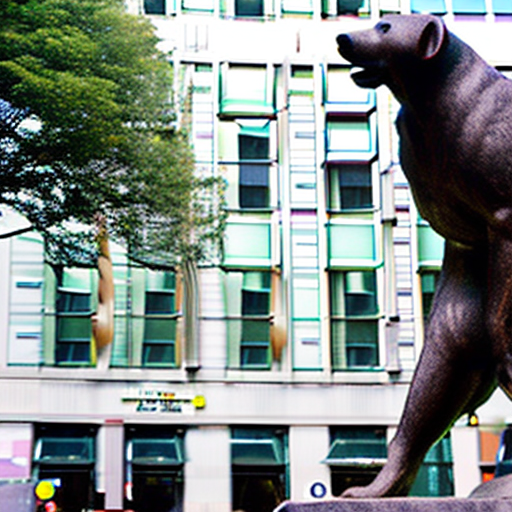

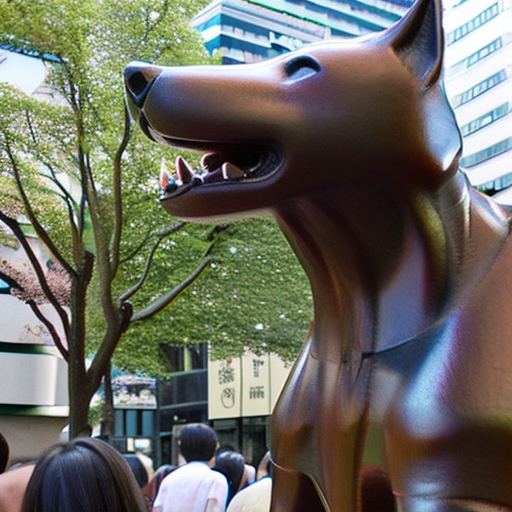

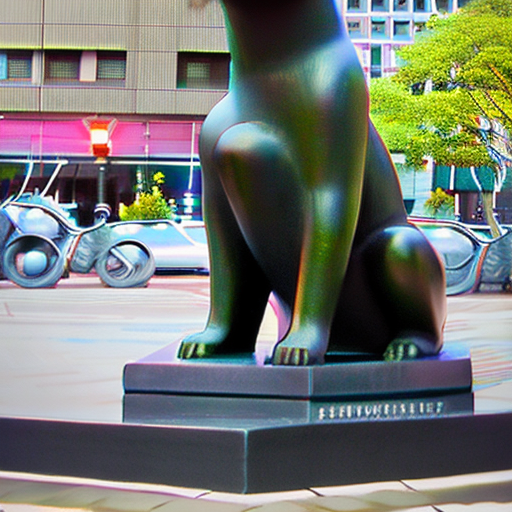

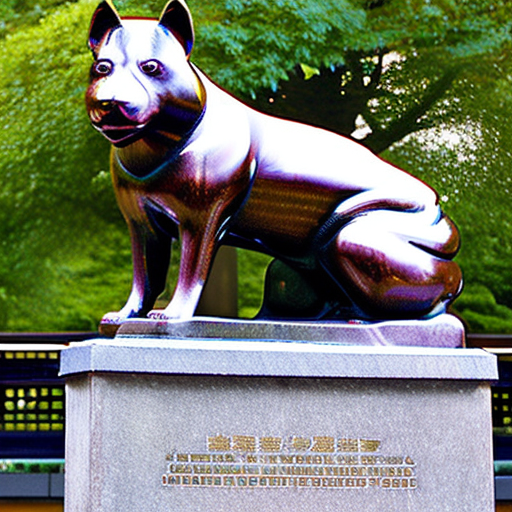

In [ ]:
batch_size = 4

# 以下の「Photo of Bronze statue of qwz Hachiko dog in Shibuya」の部分を変更して試してみてください
prompt = ["Photo of Bronze statue of waj Hachiko dog in Shibuya"] * batch_size

g_cuda = torch.Generator(device='cuda')
pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, torch_dtype=torch.float16).to("cuda")

with autocast("cuda"), torch.no_grad():
    images = pipe(prompt, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, generator=g_cuda).images

for img in images:
    display(img)